In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import os
import cv2

100%|██████████| 1/1 [00:00<00:00, 10.53it/s]


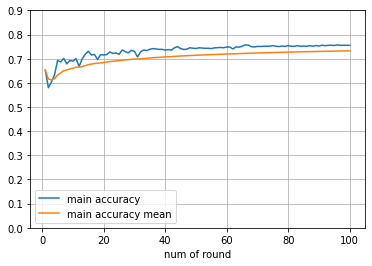

In [2]:
root = 'results/adni/'
# for folder in tqdm(os.listdir(root)):
#     for file in os.listdir(root + folder):
#         if file.endswith('npy'):
#             y = np.load(root + folder + '/' + file)
#             x = np.arange(1, len(y) + 1)
#             mean = y.cumsum() / x
#             metric = file.replace('.npy', '')
#             fig = plt.figure()
#             plt.plot(x, y, label=metric.replace('_', ' '))
#             plt.plot(x, mean, label=metric.replace('_', ' ') + ' mean')
#             plt.xlabel('num of round')
#             plt.grid(True)
#             plt.yticks(np.arange(0, 1, 0.1))
#             plt.legend()
#             plt.savefig(root + folder + '/' + metric + '.png')
#             plt.close(fig)

In [42]:
data = []
for folder in os.listdir(root):
    accuracy_m = 0
    accuracy_s = 0
    for file in os.listdir(root + folder):
        if file.endswith('.npy'):
            results = np.load(root + folder + '/' + file)
            accuracy_m = results[-len(results) // 10:].mean()
            accuracy_s = results[-len(results) // 10:].std()
            if file.startswith('backdoor'):
                break
    a = list(filter(lambda x: x, folder.split('-')))
    dataset = a[0]
    non_iid = a[1]
    aggregator = a[2]
    attack = a[3]
    fraction = 0
    if len(a) > 4:
        fraction = a[4]
    data.append((dataset, non_iid, aggregator, attack, fraction, accuracy_m, accuracy_s))

df = pd.DataFrame(data, columns=['dataset', 'non_iid', 'aggregator', 'attack', 'fraction', 'accuracy_m', 'accuracy_s'])


In [43]:
def group_and_show(df, group_by, exclusions=None):
    if exclusions:
        df = df.drop(exclusions, axis=1)
    groups = df.groupby(group_by)
    frames = []
    for i , (_, frame) in enumerate(groups):

        if i!= len(groups)-1:
            frame = frame.append(pd.Series(dtype=object), ignore_index=True)
        frames.append(frame)

    frame = pd.concat(frames).fillna('').reset_index(drop=True)

    def fill(row):
        if row.dataset == '':
            return ['background-color: #e0e2e5'] * len(row)
        return [''] * len(row)

    display(frame.style.hide_index().set_properties(**{'font-size': '.8rem'}).apply(fill, axis=1))


### Comparison of aggregators with no attacks

In [44]:
clean_results =  df[df['attack'] == 'clean']

group_and_show(clean_results, 'non_iid', ['attack', 'fraction'])
# group_and_show(clean_results, 'aggregator', ['attack', 'fraction'])

dataset,non_iid,aggregator,accuracy_m,accuracy_s
mnist,0,fedavg,0.893780,0.002107
mnist,0,krum,0.830990,0.015824
mnist,0,median,0.887490,0.002687
mnist,0,trimmedmean,0.890680,0.001911
,,,,
mnist,0.4,fedavg,0.875220,0.010985
mnist,0.4,krum,0.720650,0.014070
mnist,0.4,median,0.857450,0.012172
mnist,0.4,trimmedmean,0.876680,0.008548
,,,,


#
#
### Comparison of attacks on the baseline (fed averaging)


In [45]:
fed_avg_results =  df[df['aggregator'] == 'fedavg']
fed_avg_results = fed_avg_results[fed_avg_results['attack']!='clean']

group_and_show(fed_avg_results, 'attack', ['aggregator'])

dataset,non_iid,attack,fraction,accuracy_m,accuracy_s
mnist,0,backdoor,0.1,0.999800,0.000600
mnist,0,backdoor,0.3,0.999600,0.001200
mnist,0,backdoor,0.5,0.996000,0.000000
mnist,0.4,backdoor,0.1,1.000000,0.000000
mnist,0.4,backdoor,0.3,1.000000,0.000000
mnist,0.4,backdoor,0.5,1.000000,0.000000
mnist,0.7,backdoor,0.1,0.999400,0.000917
mnist,0.7,backdoor,0.3,0.998600,0.000917
mnist,0.7,backdoor,0.5,0.997200,0.000980
,,,,,


#
#
### Comparison of aggregators against attacks


In [46]:

defenses_results =  df[df['attack']!='clean']

for non_iid, group in defenses_results.groupby('non_iid'):
    display(HTML('<br/><h3>{}</h3>'.format('non iid degree: {}'.format(non_iid))))
    group_and_show(group.sort_values('fraction'), 'attack', ['non_iid'])



dataset,aggregator,attack,fraction,accuracy_m,accuracy_s
mnist,fedavg,backdoor,0.1,0.999800,0.000600
mnist,krum,backdoor,0.1,0.000400,0.000800
mnist,median,backdoor,0.1,0.563200,0.066748
mnist,trimmedmean,backdoor,0.1,0.993800,0.001400
mnist,median,backdoor,0.3,0.993600,0.001744
mnist,trimmedmean,backdoor,0.3,1.000000,0.000000
mnist,fedavg,backdoor,0.3,0.999600,0.001200
mnist,krum,backdoor,0.3,0.002200,0.000600
mnist,trimmedmean,backdoor,0.5,0.994600,0.000917
mnist,fedavg,backdoor,0.5,0.996000,0.000000


dataset,aggregator,attack,fraction,accuracy_m,accuracy_s
mnist,fedavg,backdoor,0.1,1.000000,0.000000
mnist,krum,backdoor,0.1,0.004800,0.009304
mnist,median,backdoor,0.1,0.466200,0.037931
mnist,trimmedmean,backdoor,0.1,0.996200,0.001077
mnist,median,backdoor,0.3,0.999600,0.000800
mnist,trimmedmean,backdoor,0.3,0.996600,0.001281
mnist,fedavg,backdoor,0.3,1.000000,0.000000
mnist,krum,backdoor,0.3,0.004800,0.006145
mnist,trimmedmean,backdoor,0.5,1.000000,0.000000
mnist,fedavg,backdoor,0.5,1.000000,0.000000


dataset,aggregator,attack,fraction,accuracy_m,accuracy_s
mnist,fedavg,backdoor,0.1,0.999400,0.000917
mnist,krum,backdoor,0.1,0.012600,0.014115
mnist,median,backdoor,0.1,0.429000,0.029370
mnist,trimmedmean,backdoor,0.1,0.995600,0.001497
mnist,median,backdoor,0.3,1.000000,0.000000
mnist,trimmedmean,backdoor,0.3,0.998400,0.000800
mnist,fedavg,backdoor,0.3,0.998600,0.000917
mnist,krum,backdoor,0.3,0.021200,0.025317
mnist,trimmedmean,backdoor,0.5,1.000000,0.000000
mnist,fedavg,backdoor,0.5,0.997200,0.000980


In [47]:

fed_avg_results =  df[df['aggregator'] == 'fedavg']
# fed_avg_results = fed_avg_results[fed_avg_results['attack']!='clean']


# plt.bar()
attack_data = {}
for attack, attack_group in fed_avg_results.groupby('attack'):
    y = {}
    for non_iid, non_iid_group in attack_group.groupby('non_iid'):
        y[non_iid] = non_iid_group['accuracy_m'].to_numpy() * 100
    attack_data[attack] = y

clean = attack_data['clean']
for attack in attack_data:
    if attack == 'clean' or attack == 'backdoor':
        continue
    data = attack_data[attack]
    for non_iid in clean:
        data[non_iid] = np.concatenate((clean[non_iid], data[non_iid]))

del attack_data['clean']

width = 0.22


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.03 * height,
                '%d' % int(height),
                ha='center', va='bottom')

x_ticks = ['Clean', '0.1', '0.3', '0.5']
y_label = 'Accuracy'
x_label = 'Fraction of malicious devices'
path = root + '0images/fedavg/'
os.makedirs(path, exist_ok=True)

plt.rcParams.update({'font.size': 13})

for attack in attack_data:
    fig = plt.figure()
    data = attack_data[attack]
    for i, non_iid in enumerate(data):
        accuracy_values = data[non_iid]
        x = np.arange(len(accuracy_values))
        autolabel(plt.bar(x + width * i, accuracy_values, width, label='non iid: ' + non_iid))
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,y1 ,y2 + 5))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(x + width, x_ticks[-len(x):])
    plt.legend(loc="lower left")
    file = path + attack + '.png'
    plt.savefig(file, bbox_inches='tight')
    plt.close(fig)



In [48]:

clean_results =  df[df['attack'] == 'clean']

# plt.bar()
clean_data = {}
for aggregator, aggregator_group in clean_results.groupby('aggregator'):
    clean_data[aggregator] = aggregator_group['accuracy_m'].to_numpy() * 100


width = 0.15


x_ticks = ['0.1', '0.4', '0.7']
y_label = 'Accuracy'
x_label = 'Non iid degree'

file = root + '0images/clean.png'


fig = plt.figure(figsize=(10, 6))

for i, aggregator in enumerate(clean_data):
    accuracy_values = clean_data[aggregator]
    x = np.arange(len(accuracy_values))
    autolabel(plt.bar(x + width * i, accuracy_values, width, label=aggregator))
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1 ,y2 + 5))
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.xticks(x + width, x_ticks[-len(x):])
plt.legend(loc="lower left")
plt.savefig(file, bbox_inches='tight')
plt.close(fig)


In [49]:
defenses_results =  df[
    (df['attack']=='labelflip') |
    (df['attack'] == 'randomupdate') |
    (df['attack'] == 'signflip') |
    (df['attack'] == 'backdoor')
]

width = 0.2

x_ticks = ['0.1', '0.3', '0.5']
y_label = 'Accuracy'
x_label = 'Fraction of malicious devices'

path = root + '0images/defences/'

for non_iid, non_iid_group in defenses_results.groupby('non_iid'):
    p = path+non_iid+'/'
    os.makedirs(p, exist_ok=True)
    for attack, attack_group in non_iid_group.groupby('attack'):
        fig = plt.figure()
        for i, (aggregator, aggregator_group) in enumerate(attack_group.groupby('aggregator')):
            accuracy_values = aggregator_group['accuracy_m'].to_numpy()*100
            x = np.arange(len(accuracy_values))
            autolabel(plt.bar(x + width * i, accuracy_values, width, label=aggregator))
        x1,x2,y1,y2 = plt.axis()
        plt.axis((x1,x2,y1 ,y2 + 5))
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(x + width, x_ticks[-len(x):])
        plt.legend(loc="lower left")
        file = p + attack + '.png'
        plt.savefig(file, bbox_inches='tight')
        plt.close(fig)

